In [60]:
import random
import matplotlib.pyplot as plt
import math
import time

In [61]:
random.seed(1)
habitable_width, habitable_length = 100, 100
a_second_in_simulation = 1/(24*60*60)

In [62]:
class Location:
    def __init__ (self, x, y):
        self.x = x
        self.y = y
    def __eq__ (self, other):
        return (self.x == other.x) and (self.y == other.y)
    def __hash__ (self):
        return hash((self.x, self.y))

In [63]:
def random_house_location():
    #naming the side on x-axis '1' and the following sides similarly in clockwise direction
    chosen_side = random.randint(1, 4)
    match chosen_side:
        case 1:
            return Location(x = random.randrange(0, habitable_length), y = 0)
        case 2:
            return Location(x = habitable_length, y = random.randrange(1, habitable_width))
        case 3:
            return Location(x = random.randrange(0, habitable_length - 1), y = habitable_width)
        case 4:
            return Location(x = 0, y = random.randrange(1, habitable_width - 1))

In [64]:
class Organism:
    def __init__ (self, location, health, energy, mass, energy_required_to_survive, surplus_energy_to_reproduce):
        self.health = health
        self.energy = energy
        self.mass = mass
        self.location = location
        self.energy_required_to_survive = energy_required_to_survive #current amount of energy required, if excess by an amount delta than reproduce
        self.surplus_energy_to_reproduce = surplus_energy_to_reproduce # if energy surplus == this amount, then reproduce
    def isAlive(self):
        return self.health > 0
    def speed(self):
        return math.sqrt(2*self.energy/self.mass)
    def move(self):
        self.location.x += random.choice([-1, 0, 1])
        self.location.y += random.choice([-1, 0, 1])

In [65]:
class Food:
    def __init__ (self, location, energy):
        self.energy = energy
        self.location = location

In [66]:
def airdrop_food(food_quantity):
    food_data = [Food(energy = random.randrange(10, 20), location = Location(random.randrange(2, habitable_length - 1), random.randrange(2, habitable_width - 1))) for _ in range(food_quantity)]
    food_map = {food.location : food for food in food_data}
    return food_map

In [67]:
class Simple_organism(Organism):
    def __init__ (self, location, health = 1, energy = 5, mass = 1, energy_required_to_survive = 10, surplus_energy_to_reproduce = 10):
        super().__init__(location, health, energy, mass, energy_required_to_survive, surplus_energy_to_reproduce)

In [68]:
def play_game(being_1, being_2):
    #returns 1 if being_1 wins
    return random.choice([0, 0.5, 1])

In [69]:
def high_precision_sleep(duration):
    start_time = time.perf_counter()
    while True:
        elapsed_time = time.perf_counter() - start_time
        remaining_time = duration - elapsed_time
        if remaining_time <= 0:
            break
        if remaining_time > 0.02:  # Sleep for 5ms if remaining time is greater
            time.sleep(max(remaining_time/2, 0.0001))  # Sleep for the remaining time or minimum sleep interval
        else:
            pass

In [70]:
food_airdropped_per_day = 100
total_fauna = 100
fauna = [Simple_organism(location = random_house_location()) for _ in range(total_fauna)] # organism spawned
fauna_alive = total_fauna
fauna_alive_history = [fauna_alive]
max_days = 100
food_map = airdrop_food(food_airdropped_per_day) #initialization
time_of_day_in_sec = 0
days_passed = 0

while days_passed <= max_days:
    print(f"Day ... {days_passed}/{max_days}", end = "\r")
    stop_clock = False
    while not stop_clock:
        high_precision_sleep(a_second_in_simulation)
        time_of_day_in_sec += 1
        i_finds_food = False
        i_meets_j = -1
        for being in fauna:          #
            if being.isAlive():      # Move all beings
                being.move()         #
        being_to_delete = []
        for i in range(len(fauna)): #using i to avoid repeated cases
            if fauna[i].isAlive():
                i_meets_j = -1
                i_finds_food = False
                for j in range(i+1, len(fauna)):
                    if not fauna[j].isAlive():
                        continue
                    if fauna[i].location == fauna[j].location:
                        i_meets_j = j
                        break
                if fauna[i].location in food_map:
                    i_finds_food = True
                if i_finds_food and not i_meets_j == -1:
                    #distribute food among i and j based on the result of a game between i and j
                    #for game, 1 indicates winning, 0 for losing and 0.5 for a draw
                    i_wins = play_game(fauna[i], fauna[i_meets_j])
                    fauna[i].energy += i_wins * food_map[fauna[i].location].energy
                    fauna[i_meets_j].energy += (1 - i_wins) * food_map[fauna[i_meets_j].location].energy
                    del food_map[fauna[i].location]
                elif i_finds_food and i_meets_j == -1:
                    fauna[i].energy += food_map[fauna[i].location].energy
                elif not i_finds_food and not i_meets_j == -1:
                    i_wins = play_game(fauna[i], fauna[i_meets_j])
                    #loser dies
                    if i_wins == 1:
                        being_to_delete.append(i_meets_j)
                        fauna[i_meets_j].health = 0
                        fauna_alive -= 1
                    elif i_wins == 0:
                        being_to_delete.append(i)
                        fauna[i].health = 0
                        fauna_alive -= 1
                    #else both live
        being_to_delete.sort(reverse = True)
        for i in being_to_delete:
            del fauna[i]
        if time_of_day_in_sec == 86400: #60*60*24,i.e., a day has passed, now check who has the energy to survive 
            days_passed += 1
            time_of_day_in_sec = 0
            stop_clock = True
            for being in fauna:
                if being.isAlive():
                    if being.energy >= being.energy_required_to_survive:
                        # being survives
                        being.health = 1
                        being.energy -= being.energy_required_to_survive
                        if being.energy >= being.surplus_energy_to_reproduce:
                            #being reproduces
                            fauna.append(Simple_organism(location = random_house_location()))
                            fauna_alive += 1
                            being.energy -= being.surplus_energy_to_reproduce
                        #being is still alive, therefore, it goes back to the village
                        being.location = random_house_location()
                    else:
                        #being dies
                        being.health = 0
                        fauna_alive -= 1
            fauna_alive_history.append(fauna_alive)

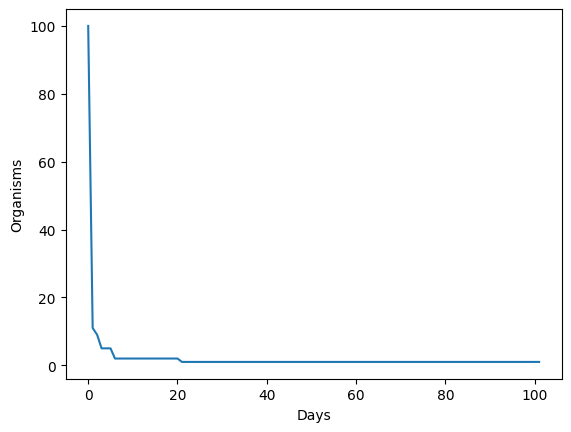

In [71]:
plt.plot(fauna_alive_history, label = "History")
plt.xlabel('Days')
plt.ylabel('Organisms')
plt.show()